In [17]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using TensorTrains: summary_compact;

In [18]:
T = 20
N = 100
c = 2.5
seed = 5
gg = erdos_renyi(N, c/N; seed)
N = nv(gg)
g = IndexedGraph(gg)
λ = 0.4
ρ = 0.15
σ = 0.15
γ = 1/N;

sirs = SIRS(g, λ, ρ, σ, T; γ);

In [19]:
bp = mpbp(sirs)
obs_times = [10]
nobs = floor(Int, N * length(obs_times) * 0.75)
obs_fraction = nobs / N
rng = MersenneTwister(seed)
X, observed = draw_node_observations!(bp, nobs, times = obs_times .+ 1, softinf=Inf; rng);
# X, observed = draw_node_observations!(bp, nobs, softinf=Inf; rng);
sum(X[:, obs_times .+ 1] .!= 1), sum(X[:, 1] .== 2)

(64, 1)

In [24]:
using ProgressMeter
# A callback to print info and save stuff during the iterations 
struct CB_BP2{TP<:ProgressUnknown, F, XT}
    prog :: TP
    m    :: Vector{Vector{Vector{Float64}}} 
    Δs   :: Vector{Float64}
    f    :: F
    X    :: XT

    function CB_BP2(bp::MPBP, X::XT; showprogress::Bool=true, f::F=(x,i)->x, info="") where {F, XT}
        dt = showprogress ? 0.1 : Inf
        isempty(info) || (info *= "\n")
        prog = ProgressUnknown(desc=info*"Running MPBP: iter", dt=dt)
        TP = typeof(prog)

        m = [[expectation.(x->f(x,i), marginals(bp.b[i])) for i in eachindex(bp.b)]]
        Δs = zeros(0)
        new{TP,F, XT}(prog, m, Δs, f, X)
    end
end

function (cb::CB_BP2)(bp::MPBP, it::Integer, svd_trunc::SVDTrunc)
    marg_new = [expectation.(x->cb.f(x,i), marginals(bp.b[i])) for i in eachindex(bp.b)]
    marg_old = cb.m[end]
    Δ = isempty(marg_new) ? NaN : mean(mean(abs, mn .- mo) for (mn, mo) in zip(marg_new, marg_old))
    push!(cb.Δs, Δ)
    push!(cb.m, marg_new)
    b_bp = beliefs(bp)
    next!(cb.prog, showvalues=[(:Δ,Δ), summary_compact(svd_trunc), (:O, sum(b_bp[i][t][X[i,t]] for t = 1:T, i = 1:N))])
    flush(stdout)
    return Δ
end

In [25]:
reset!(bp)
cb = CB_BP2(bp, X);

In [26]:
iters, = iterate!(bp, maxiter=50; svd_trunc = TruncBond(3), cb, tol=1e-4, damp=0.5);

Running MPBP: iter 50    Time: 0:00:39
  Δ:                0.00022497622884509513
  SVD Matrix size:  3


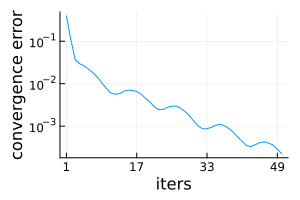

In [27]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [28]:
b_bp = beliefs(bp)
p_bp = [[bᵗ[INFECTIOUS] for bᵗ in bb] for bb in b_bp];

In [29]:
true_infections = [UnitRange{Int64}[] for _ in 1:N]
for i in 1:N
    start = -1
    for t in 1:T+1
        if X[i,t] == INFECTIOUS
            start == -1 && (start = t)
        else
            start != -1 && ( push!(true_infections[i], start-1:t-2); start = -1 )
        end
    end
    start != -1 && push!(true_infections[i], start-1:T)
    push!(true_infections[i], T+1:T+2)
end

In [30]:
using ColorSchemes
cg = cgrad([theme_palette(:auto)[1], :yellow], 0.6)

In [31]:
Tplot = T
X_bp = reduce(hcat, p_bp)

perm = sortperm(true_infections)
true_infections_sorted = true_infections[perm]
X_bp_sorted = X_bp[:,perm]

pl = heatmap(1:N, 0:T, X_bp_sorted, yrange=(0,Tplot), c=cg, xlabel="i", ylabel="t", colorbar_title="\$P(x_i^t=I)\$")

pl2 = deepcopy(pl)
pl3 = plot(xlabel="i", ylabel="t", xlims=(1,N), yrange=(0,Tplot));

In [32]:
cols = [:white, :red, :black]
markers = [:circle, :diamond, :star]
iperm = invperm(perm)
for (i,t) in observed
    scatter!(pl, iperm[i:i], [t-1], m=:o, ms=3, msc=:black, c=cols[X[i,t]], label="")
end

In [33]:
label = "true infections"
for i in 1:N
    for a in true_infections_sorted[i]
        plot!(pl, [i,i], [a.start-0.1,a.stop+0.1], c=:black, label=label, lw=1)
        label = ""
        plot!(pl3, [i,i], [a.start-0.1,a.stop+0.1], c=:black, label=label, lw=1)
    end
end

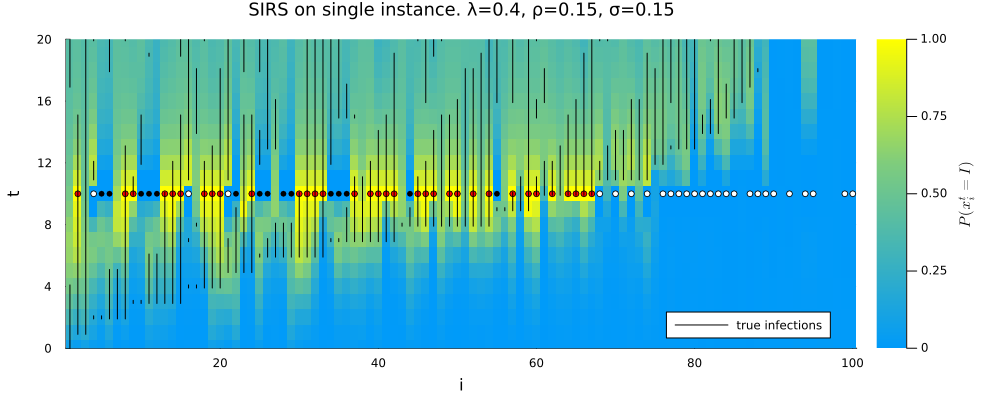

In [34]:
plot(pl, margin=5Plots.mm, 
    title="SIRS on single instance. λ=$(round(λ, digits=3)), ρ=$(round(ρ, digits=3)), σ=$(round(σ, digits=3))",
    titlefontsize=12, size=(1000,400), yrange=(0,Tplot), legend=:bottomright, yticks=0:(T÷5):T, widen=false)

In [35]:
zero_patients_true = findall(isequal(INFECTIOUS), X[:,1])
@show zero_patients_true
sortperm(X_bp[1,:], rev=true)[1:10]

zero_patients_true = [86]


10-element Vector{Int64}:
 13
 97
 86
 52
 42
 27
 80
 72
 41
 31

In [36]:
println("Ranking of zero patients")
[findall(isequal(zp), sortperm(X_bp[1,:], rev=true)) for zp in zero_patients_true]

Ranking of zero patients


1-element Vector{Vector{Int64}}:
 [3]

In [19]:
# jldsave("plot_data/sirs_inference_single_instance.jld2"; 
#     N, T, X, X_bp_sorted, true_infections_sorted, iperm, obs_times, c, λ, ρ, σ, γ, 
#     observed, obs_fraction);